# Segmentação semântica de imagens

Entende se que você viu a classificação de imagens, em que a tarefa da rede é atribuir um rótulo ou classe a uma imagem de entrada. 

No entanto, suponha que você queira saber onde um objeto está localizado na imagem, a forma desse objeto, qual pixel pertence a qual objeto etc. 
Nesse caso, você desejará segmentar a imagem, ou seja, para cada pixel da imagem é dado um rótulo. 
Assim, a tarefa da segmentação de imagens é treinar uma rede neural para produzir uma máscara da imagem em pixels. 
Isso ajuda a entender a imagem em um nível muito mais baixo, isto é, o nível de pixel. 
A segmentação de imagens tem muitas aplicações em imagens médicas, carros autônomos e imagens de satélite, para citar alguns.

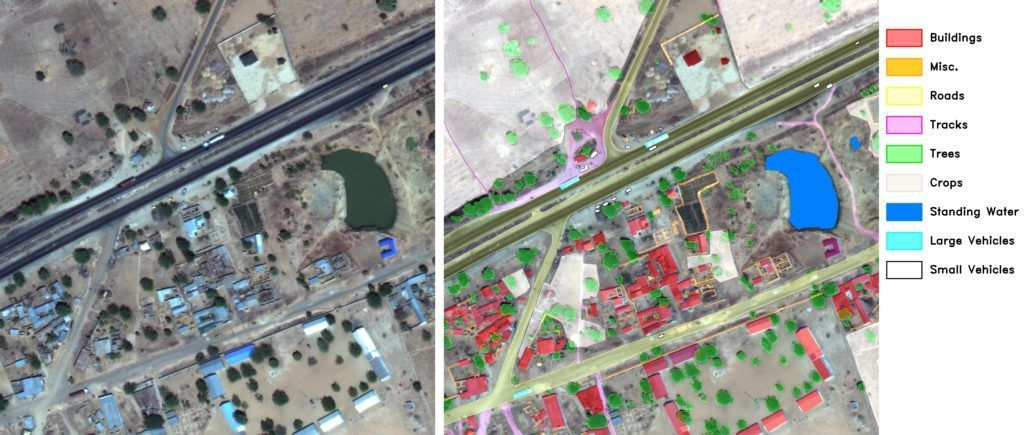

Mais precisamente, a segmentação semântica de imagens é a tarefa de rotular cada pixel da imagem em um conjunto predefinido de classes. Por exemplo, vários objetos como carros, árvores, pessoas, sinais de trânsito etc. podem ser usados como classes para segmentação semântica de imagens. Portanto, a tarefa é pegar uma imagem (RGB ou escala de cinza) e produzir uma matriz W x H x 1, onde W e H representam a largura e a altura da imagem, respectivamente. Cada célula nesta matriz conteria os IDs de classe previstos para cada pixel na imagem.

No Deep learning, expressamos rótulos de classe categórica como vetores codificados one-hot. Da mesma forma, na segmentação semântica, podemos expressar a matriz de saída usando um esquema de codificação one-hot essencialmente criando um canal para cada rótulo de classe e marcando as células por 1 que contêm o pixel da classe correspondente e marcando as células restantes por 0.

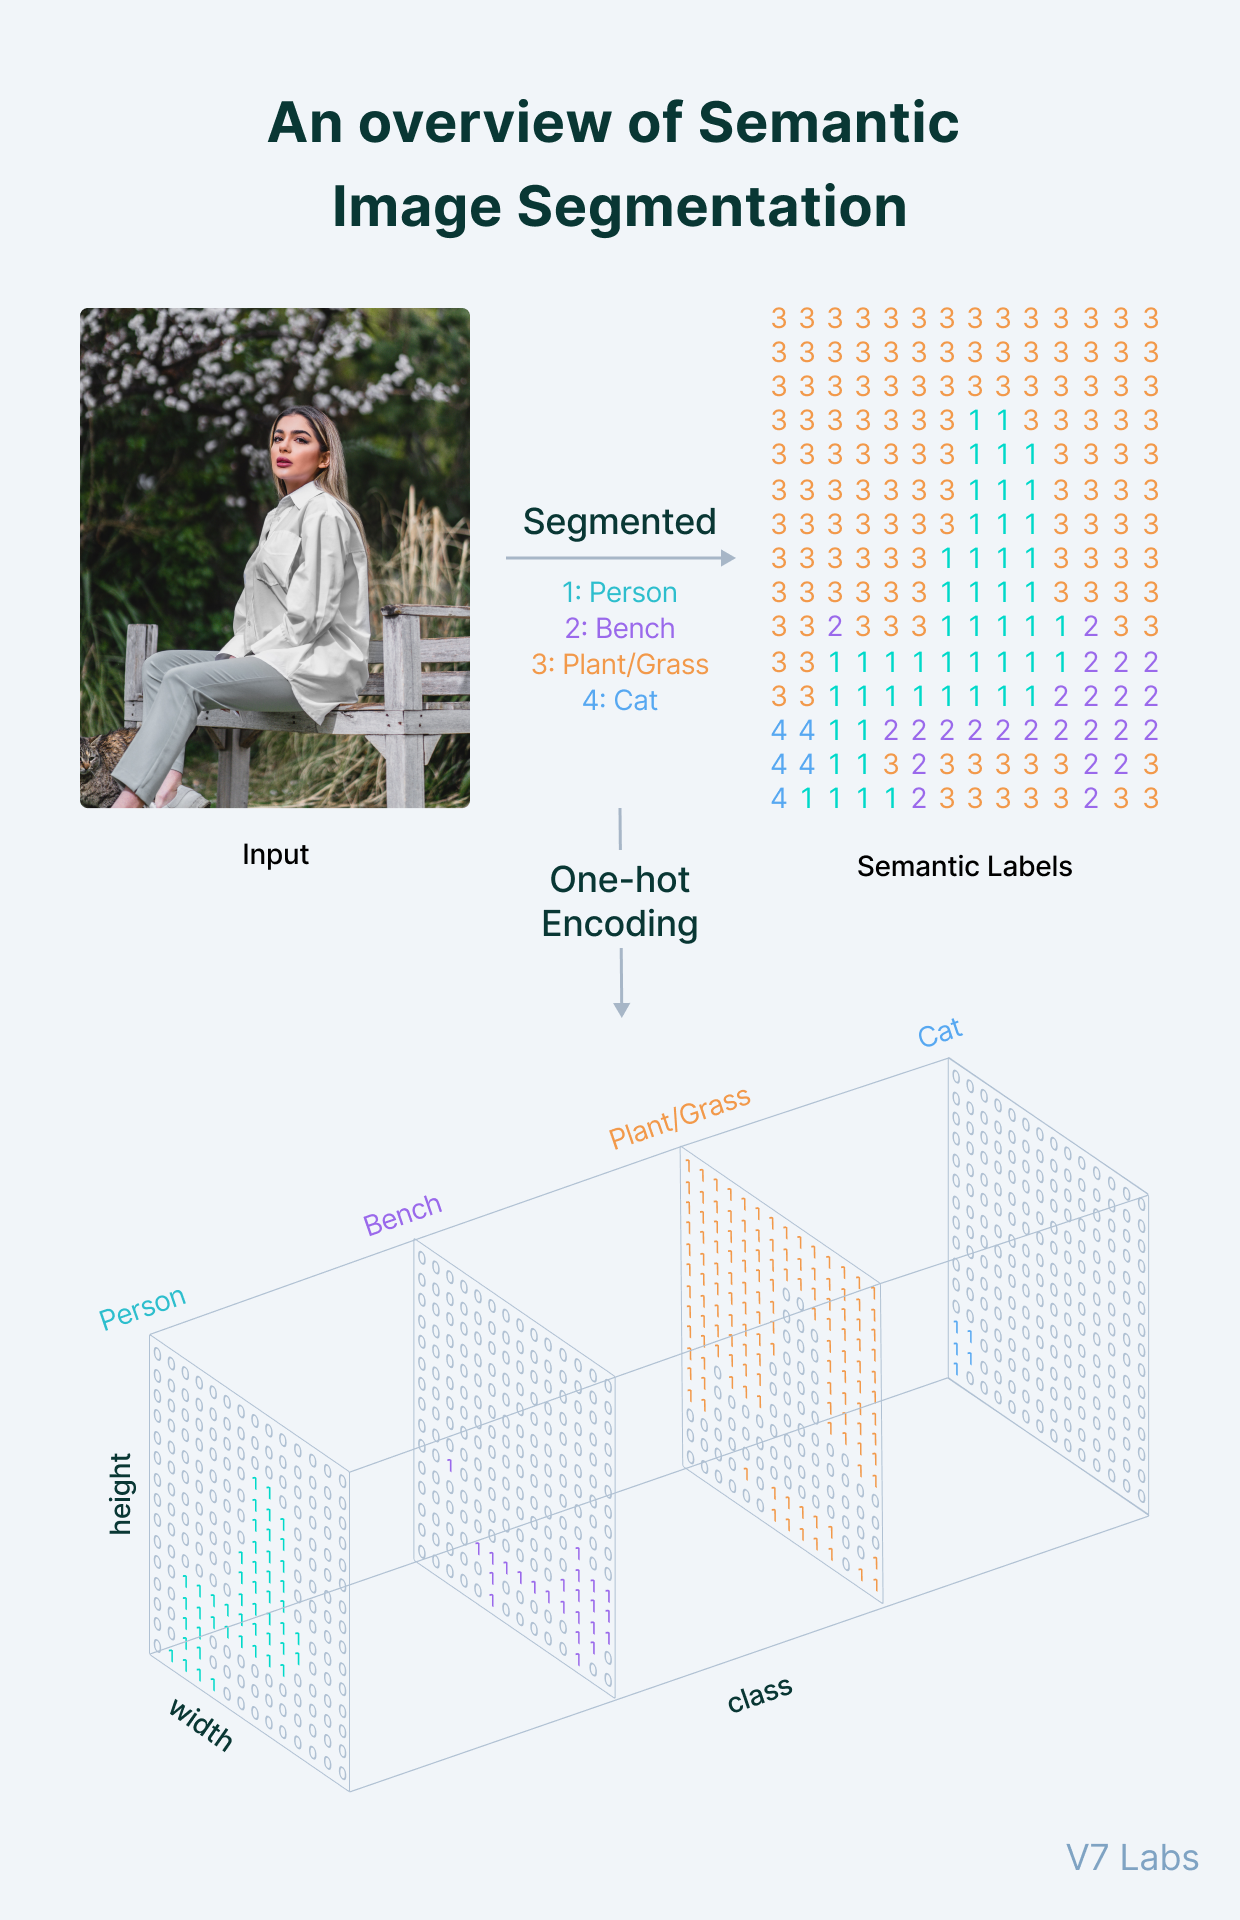

Como outras tarefas de visão computacional, usar uma CNN para segmentação semântica seria a escolha óbvia. Ao usar CNN para segmentação semântica, a saída seria uma imagem com a mesma resolução da entrada, diferentemente de um vetor de comprimento fixo no caso de classificação de imagens.
A arquitetura geral dos modelos contém uma série de camadas convolucionais juntamente com camadas convolucionais agrupadas ou strided para downsampling. Para melhorar o modelo, também são utilizadas ativações não lineares e camadas de normalização em lote.
As camadas iniciais em uma rede neural convolucional aprendem recursos de baixo nível, como linhas, bordas, cores, etc., e as camadas mais profundas aprendem recursos de alto nível, como rostos ou objetos, etc.

Agora que obtivemos esse tensor de baixa resolução, de alguma forma temos que aumentar sua resolução até a imagem original para cumprir a tarefa de segmentação semântica. Alimentamos este mapa de recursos de baixa resolução para camadas de upsampling seguidas por mais camadas de convolução para criar mapas de recursos de resolução mais alta. À medida que aumentamos a resolução, diminuímos simultaneamente o número de canais nos mapas de recursos. Este tipo de arquitetura é conhecido como arquitetura codificador-decodificador. A fase de downsampling é conhecida como codificador e a fase de upsampling é chamada de decodificador.

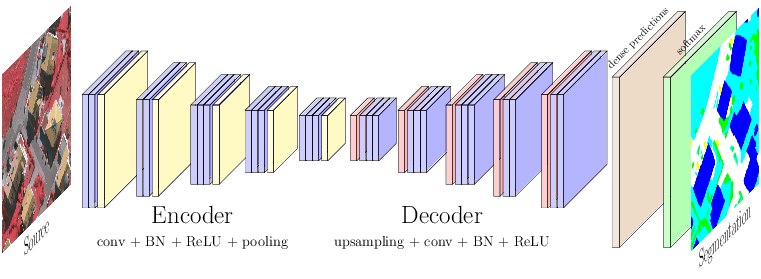

## U-Net

U-Net é uma arquitetura desenvolvida por Olaf Ronneberger et al. para Segmentação de Imagens Biomédicas em 2015 na Universidade de Freiburg, Alemanha. É uma das abordagens mais popularmente usadas em qualquer tarefa de segmentação semântica hoje. É uma rede neural totalmente convolucional projetada para aprender com menos amostras de treinamento. É uma melhoria em relação ao FCN existente – “Redes totalmente convolucionais para segmentação semântica” desenvolvido por Jonathan Long et al. em 2014).

U-Net é uma arquitetura de rede codificador-decodificador em forma de U, que consiste em quatro blocos codificadores e quatro blocos decodificadores conectados por meio de uma ponte. A rede do codificador (caminho de contração) metade das dimensões espaciais e o dobro do número de filtros (canais de recursos) em cada bloco do codificador. Da mesma forma, a rede de decodificadores dobra as dimensões espaciais e metade do número de canais de recursos.

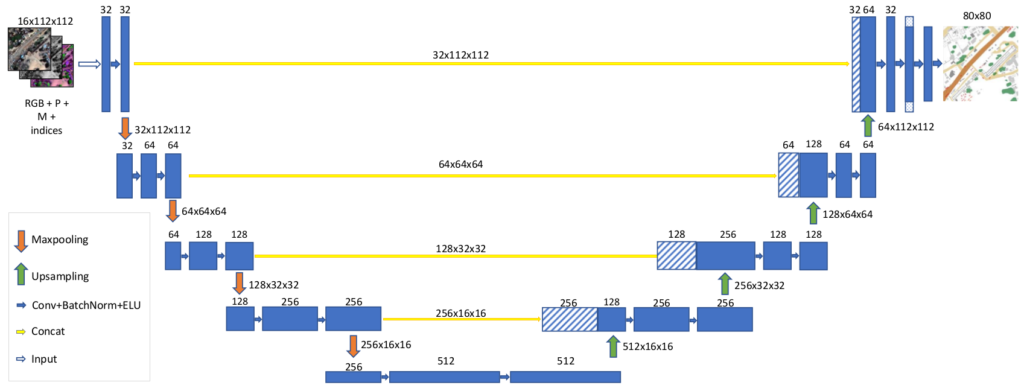

Codificador

O codificador atua como o extrator de recursos e aprende uma representação abstrata da imagem de entrada por meio de uma sequência de blocos do codificador. Cada bloco do codificador consiste em duas convoluções 3x3, onde cada convolução é seguida por uma função de ativação ReLU (Rectified Linear Unit). A função de ativação ReLU introduz não linearidade na rede, o que ajuda na melhor generalização dos dados de treinamento. A saída do ReLU atua como uma conexão de salto para o bloco decodificador correspondente.
Em seguida, segue um 2x2 max-pooling, onde as dimensões espaciais (altura e largura) dos mapas de recursos são reduzidas pela metade. Isso reduz o custo computacional diminuindo o número de parâmetros treináveis.

As skips connection fornecem informações adicionais que ajudam o decodificador a gerar melhores recursos semânticos. Eles também atuam como uma conexão de atalho que ajuda o fluxo indireto de gradientes para as camadas anteriores sem qualquer degradação. Em termos simples, podemos dizer que a skip connection ajuda no melhor fluxo de gradiente enquanto backpropagation, o que por sua vez ajuda a rede a aprender uma melhor representação.




Decodificador

O decodificador é usado para pegar a representação abstrata e gerar uma máscara de segmentação semântica. O bloco decodificador começa com uma convolução de transposição 2x2. Em seguida, ele é concatenado com o mapa de recursos da skip connection correspondente do bloco do codificador. Essas skips connections fornecem recursos de camadas anteriores que às vezes são perdidos devido à profundidade da rede. Depois disso, são utilizadas duas convoluções 3x3, onde cada convolução é seguida por uma função de ativação ReLU.
A saída do último decodificador passa por uma convolução 1x1 com ativação sigmóide. A função de ativação sigmóide fornece a máscara de segmentação que representa a classificação pixel a pixel.

# Estudo de Caso: Segmentação de Áreas Construídas com U-Net

Instalando local as bibliotecas que vamos utilizar.

In [ ]:
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install opencv-python-headless
%pip install pandas
%pip install keras
%pip install keras.utils
%pip install tensorflow
%pip install scikit-image

Importamos as bibliotecas e funções que vamos precisar:

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras
print(keras.__version__)

Agora, vamos definir os caminhos das imagens de máscaras de treinamento, imagens e máscaras de validação e as imagens de teste:

In [ ]:
import os

# Obtendo o diretório atual onde o notebook está rodando
notebook_dir = os.getcwd()

# Diretório base onde estão suas imagens
base_dir = notebook_dir + '\\data'

# Imprimindo o diretório de dados das imagens
print(f"O BaseDir está localizado em: {base_dir}")

# Diretórios específicos
IMGS_TRAIN_DIR = os.path.join(base_dir, "train_img")
MASKS_TRAIN_DIR = os.path.join(base_dir, "train_label")
IMGS_VAL_DIR = os.path.join(base_dir, "val_img")
MASKS_VAL_DIR = os.path.join(base_dir, "val_label")
IMGS_TEST_DIR = os.path.join(base_dir, "test_img")

# Exibindo os caminhos
print(f"Diretório de treinamento: {IMGS_TRAIN_DIR}")
print(f"Diretório de validação: {IMGS_VAL_DIR}")
print(f"Diretório de teste: {IMGS_TEST_DIR}")



In [94]:
train_img_list = os.listdir(IMGS_TRAIN_DIR)
train_msk_list = os.listdir(MASKS_TRAIN_DIR)

In [95]:
train_img_list.sort()
train_msk_list.sort()

Então podemos iniciar a importação das imagens e máscaras que serão usadas no treinamento:

In [96]:
X_train = []
Y_train = []
for img in train_img_list:
  img_filename = os.path.join(IMGS_TRAIN_DIR,img)
  mask_filename = os.path.join(MASKS_TRAIN_DIR,img)
  img = cv2.imread(img_filename)
  mask = cv2.imread(mask_filename)
  X_train.append(img)
  Y_train.append(mask[:,:,0:1])

In [97]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Assim podemos ver o tamanho dos nosso dados de treinamento:

In [ ]:
print(X_train.shape)
print(Y_train.shape)

Vamos plotar um exemplo de uma imagem e de sua respectiva máscara:

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(X_train[20])
plt.axis('off')

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(Y_train[20,:,:,0])
plt.axis('off')

Também importamos as imagens e máscaras para validação:

In [101]:
val_img_list = os.listdir(IMGS_VAL_DIR)
val_msk_list = os.listdir(MASKS_VAL_DIR)

In [102]:
val_img_list.sort()
val_msk_list.sort()

In [103]:
X_val = []
Y_val = []
for img in val_img_list:
  img_filename = os.path.join(IMGS_VAL_DIR,img)
  mask_filename = os.path.join(MASKS_VAL_DIR,img)
  img = cv2.imread(img_filename)
  mask = cv2.imread(mask_filename)
  X_val.append(img)
  Y_val.append(mask[:,:,0:1])

In [104]:
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [ ]:
print(X_val.shape)
print(Y_val.shape)

E por fim, importamos as imagens de teste:

In [106]:
test_img_list = os.listdir(IMGS_TEST_DIR)

In [107]:
test_img_list.sort()

In [108]:
X_test = []
for img in test_img_list:
  img_filename = os.path.join(IMGS_TEST_DIR,img)
  img = cv2.imread(img_filename)
  X_test.append(img)

In [109]:
X_test = np.array(X_test)

In [ ]:
print(X_test.shape)

Como temos imagens RGB com um range de 0 à 255, vamos dividir nossos dados por 255 para termos apenas valores em um range de 0 a 1.

In [111]:
X_train = X_train/255
Y_train = Y_train/255

In [112]:
X_val = X_val/255
Y_val = Y_val/255

Após preparar os dados vamos usar algumas funções do Keras:

In [113]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, add, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add, AveragePooling2D, Lambda, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, ZeroPadding2D, LeakyReLU
from keras.activations import relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
from keras.models import load_model
from keras.models import model_from_json
from keras.optimizers import Adam

Primeiro implementamos as funções jaccard loss e a dice loss:

In [114]:
def jaccard_coef(y_true, y_pred,smooth=100):
  # __author__ = Vladimir Iglovikov
  intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
  sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

  jac = (intersection + smooth) / (sum_ - intersection + smooth)

  return K.mean(jac)

def jaccard_loss(y_true, y_pred):
  return 1 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Depois implementamos um aumento de dados, tanto para as máscaras, quanto para as imagens:

In [115]:
img_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2)

mask_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2)

In [116]:
img_datagen.fit(X_train, augment=True,seed=1200)
mask_datagen.fit(Y_train, augment=True,seed=1200)

In [117]:
X=img_datagen.flow(X_train,batch_size=6,seed=1200)
Y=mask_datagen.flow(Y_train,batch_size=6,seed=1200)

In [118]:
#train_generator = zip(X, Y)
def combined_generator(generator1, generator2):
    while True:
        x1 = next(generator1)
        x2 = next(generator2)
        yield (x1, x2)

# Crie o gerador combinando dois outros
train_generator = combined_generator(X, Y)

In [119]:
steps_per_epoch = len(X_train)//6
validation_steps = len(X_val)//6

## Unet

Agora podemos implementar a nossa U-Net usando o Keras:

In [ ]:
upconv = True
droprate = 0.3
inputs = Input(shape=X_train.shape[1:])
conv1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


pool1 = BatchNormalization()(pool1)
conv2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(droprate)(pool2)

pool2 = BatchNormalization()(pool2)
conv3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(droprate)(pool3)

pool3 = BatchNormalization()(pool3)
conv4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(droprate)(pool4)

pool4 = BatchNormalization()(pool4)
conv5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
pool5 = Dropout(droprate)(pool5)

pool5 = BatchNormalization()(pool5)
conv6 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)
conv6 = Dropout(droprate)(conv6)

if upconv:
  up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6), conv5])
else:
  up6 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv5])
up6 = BatchNormalization()(up6)
conv7 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up6)
conv7 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv7)
conv7 = Dropout(droprate)(conv7)

if upconv:
  up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7), conv4])
else:
  up7 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv4])
up7 = BatchNormalization()(up7)
conv8 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up7)
conv8 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv8)
conv8 = Dropout(droprate)(conv8)

if upconv:
  up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8), conv3])
else:
  up8 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv3])
up8 = BatchNormalization()(up8)
conv9 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up8)
conv9 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv9)
conv9 = Dropout(droprate)(conv9)

if upconv:
  up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9), conv2])
else:
  up9 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv2])
up9 = BatchNormalization()(up9)
conv10 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up9)
conv10 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv10)
conv10 = Dropout(droprate)(conv10)

if upconv:
  up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10), conv1])
else:
  up10 = concatenate([UpSampling2D(size=(2, 2))(conv10), conv1])
up10 = BatchNormalization()(up10)
conv11 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up10)
conv11 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv11)


conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)
model = Model(inputs=inputs, outputs=conv12)

model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-6), loss=jaccard_loss, metrics=[jaccard_coef, 'accuracy'])
model.summary()

## ResUnet

ResUNet refere-se a U-Net Residual Profunda. É uma arquitetura codificador-decodificador desenvolvida por Zhengxin Zhang et al. para segmentação semântica. Foi inicialmente utilizado para a extração de estradas a partir de imagens aéreas de alta resolução no campo de análise de imagens de sensoriamento remoto. Mais tarde, foi adotado por pesquisadores para várias outras aplicações, como segmentação de pólipos, segmentação de tumores cerebrais, segmentação de imagens humanas e muito mais.

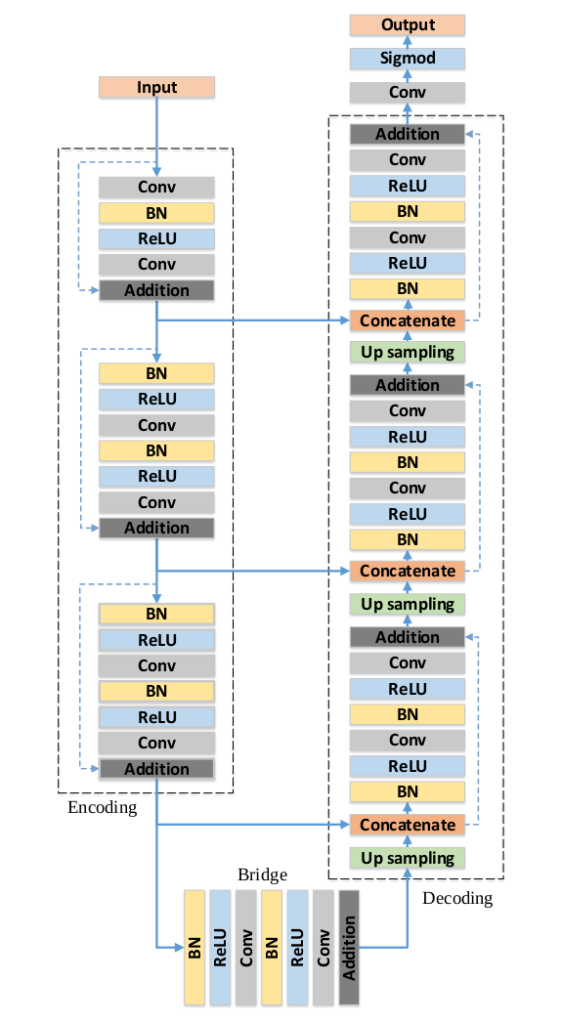

Também podemos implementar a ResUnet com o Keras:

In [121]:
def conv_block(input_tensor, filters, strides, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, strides=strides, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def identity_block(input_tensor, filters, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)

    return x

def one_side_pad(x):
    x = ZeroPadding2D((1, 1))(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x

In [ ]:
shape = X_train.shape[1:]
droprate = 0.30
inputs = Input(shape)
conv_1 = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
f1 = conv_1

conv_2 = Conv2D(64, (3, 3), strides=(2, 2), kernel_initializer='he_uniform', padding='same')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

conv_3 = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)

f2 = conv_3


pool_1 = MaxPooling2D((2, 2), strides=(2, 2))(conv_3)

conv_block1 = conv_block(pool_1, filters=[64, 64, 256], strides=(1, 1), d_rates=[1, 1, 1])
identity_block1 = identity_block(conv_block1, filters=[64, 64, 256], d_rates=[1, 1, 1])
identity_block2 = identity_block(identity_block1, filters=[64, 64, 256], d_rates=[1, 1, 1])
f3 = identity_block2

conv_block2 = conv_block(identity_block2, filters=[128, 128, 256], strides=(2, 2), d_rates=[1, 1, 1])
identity_block3 = identity_block(conv_block2, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block4 = identity_block(identity_block3, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block5 = identity_block(identity_block4, filters=[128, 128, 256], d_rates=[1, 1, 1])
f4 = identity_block5

identity_block10 = conv_block(identity_block5, filters=[256, 256, 512], strides=(2, 2), d_rates=[1, 1, 1])
for i in range(5):
  identity_block10 = identity_block(identity_block10, filters=[256, 256, 512], d_rates=[1, 2, 1])

f5 = identity_block10

conv_block4 = conv_block(identity_block10, filters=[512, 512, 1024], strides=(2, 2), d_rates=[1, 1, 1])
identity_block11 = identity_block(conv_block4, filters=[512, 512, 1024], d_rates=[1, 2, 1])
identity_block12 = identity_block(identity_block11, filters=[512, 512, 1024], d_rates=[1, 2, 1])
f6 = identity_block12

o = f6

o = (BatchNormalization())(o)
o = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)

o = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f5]))
o = (BatchNormalization())(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f4]))
o = (BatchNormalization())(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f3]))
o = (BatchNormalization())(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f2]))
o = (BatchNormalization())(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)

#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f1]))
o = (BatchNormalization())(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)


o = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(o)

model = Model(inputs=inputs, outputs=o)

model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-6), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])
model.summary()

Após compilar a arquitetura, passamos os dados de treinamento e validação e iniciamos o treinamento:

In [123]:
from tensorflow.keras import backend as K

# Função para o coeficiente Dice
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)  # Corrigido o uso de flatten
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Função de perda baseada no coeficiente Dice
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)



In [ ]:
# Verificação dos valores
print(f"train_generator: {train_generator}")
print(f"steps_per_epoch: {steps_per_epoch}")
print(f"validation_steps: {validation_steps}")
print(f"X_val: {X_val}")
print(f"Y_val: {Y_val}")

if train_generator is None:
    raise ValueError("train_generator não pode ser None")
if steps_per_epoch is None:
    raise ValueError("steps_per_epoch não pode ser None")
if validation_steps is None:
    raise ValueError("validation_steps não pode ser None")
if X_val is None or Y_val is None:
    raise ValueError("X_val e Y_val não podem ser None")

# Verificação adicional para garantir que os valores são iteráveis
try:
    iter(train_generator)
except TypeError:
    raise ValueError("train_generator deve ser iterável")

try:
    iter(X_val)
    iter(Y_val)
except TypeError:
    raise ValueError("X_val e Y_val devem ser iteráveis")

# Verificação para garantir que steps_per_epoch e validation_steps são inteiros positivos
if not isinstance(steps_per_epoch, int) or steps_per_epoch <= 0:
    raise ValueError("steps_per_epoch deve ser um inteiro positivo")
if not isinstance(validation_steps, int) or validation_steps <= 0:
    raise ValueError("validation_steps deve ser um inteiro positivo")

# Verificação para garantir que X_val e Y_val não contenham elementos None
if any(x is None for x in X_val):
    raise ValueError("X_val não deve conter elementos None")
if any(y is None for y in Y_val):
    raise ValueError("Y_val não deve conter elementos None")

# Chamada para model.fit
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                    epochs=600, validation_data=(X_val, Y_val))

Após finalizar o treinamento vamos plotas a curva de acurácia e a curva de loss:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Vamos também ver a acurácia no dataset de treinamento:

In [ ]:
predict = model.predict(X_train)
pred = np.round(predict)
true = Y_train
accuracy = accuracy_score(true.flatten(),pred.flatten())
print('Acuraccy on Train Set: ',accuracy)

Assim podemos predizer algumas imagens que foram usadas no treinamento e comparar com a mascara original:

In [ ]:
predict = model.predict(X_val)

In [ ]:
i = 2
plt.figure(figsize=[30,30])
plt.subplot(131)
plt.imshow(X_val[i,:,:,0:3])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.round(Y_val[i,:,:,0]))
plt.title('True Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.round(predict[i,:,:,0]))
plt.title('Predict Image')
plt.axis('off')

Vamos calcuar a acurácia nos dados de validação:

In [ ]:
pred = np.round(predict)
true = Y_val
accuracy = accuracy_score(true.flatten(),pred.flatten())
print('Acuraccy on Validation Set: ',accuracy)

E por fim, vamos predizer as imagens de teste que nunca foram usadas para treinar ou validar o modelo de segmentação:

In [ ]:
X_test = X_test/255

In [ ]:
predict = model.predict(X_test)

Plotamos a comparação da imagem RGB com a máscara predita do modelo:

In [ ]:
i = 0
plt.figure(figsize=[30,30])
plt.subplot(121)
plt.imshow(X_test[i,:,:,0:3])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.round(predict[i,:,:,0]))
plt.title('Predict Image')
plt.axis('off')

Também podemos salvar as máscaras preditas em imagens e armazena-las em uma pasta no content do Colab, possibilitando realizar o donwload dessas imagens:

In [ ]:
if not os.path.isdir('/content/predict'):
    os.mkdir('/content/predict')

In [ ]:
save_path = '/content/predict'

In [ ]:
for i in range(len(predict)):
  im = np.round(predict[i])
  full_im = im * 255
  full_im = full_im.astype('uint8')
  full_save_path = os.path.join(save_path,test_img_list[i])
  print(full_save_path)
  cv2.imwrite(full_save_path, full_im)

